In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import Image

import os, sys, re, datetime, time
from pathlib import Path

pj_dir = Path(os.getcwd()).parents[0]
data_dir = pj_dir/'data'
img_dir = pj_dir/'images'
src_dir = pj_dir/'src'
sys.path.append(str(src_dir))

from matplotlib import pyplot as plt
import japanize_matplotlib
import seaborn as sns
plt.style.use("bmh")
import numpy as np
import pandas as pd
import dask.dataframe as dd

from tqdm import tqdm_notebook
from dotenv import load_dotenv

In [3]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (16, 4)
plt.rcParams["font.family"] = "IPAexGothic"
import logging
logging.basicConfig(level=logging.INFO)

In [4]:
import MeCab
from sklearn.manifold import TSNE
from wordcloud import WordCloud

from gensim import models
from gensim.models.doc2vec import TaggedDocument

INFO:summarizer.preprocessing.cleaner:'pattern' package not found; tag filters are not available for English


In [5]:
df = pd.read_pickle(pj_dir/'advent_calendar/data/article_all.pickle')

In [6]:
def split_into_words(doc):
    mecab = MeCab.Tagger("-Ochasen -d /usr/local/lib/mecab/dic/mecab-ipadic-neologd")
    lines = mecab.parse(doc).splitlines()
    words = []
    for line in lines:
        chunks = line.split('\t')
        if len(chunks) > 3 and (chunks[3].startswith('名詞') and not chunks[3].startswith('名詞-数')):
            words.append(chunks[0])
    return words

In [7]:
from collections import defaultdict

In [9]:
dic_words = defaultdict(list)
for i, row in tqdm_notebook(df.iterrows()):
    content, year = row['content'], row['year']
    if pd.isna(content):
        continue
    words = split_into_words(content)
    dic_words[year].extend(words)

In [25]:
stop_words = [ 
        'Advent', 'Calendar', '利用', '場合', '使用', '今回', '以下', '実装', '感じ', '必要', '作成',
        '設定', '必要', 'コード', '追加', '機能', 'みたい', '処理', '実行', 'データ', '対応', 
        '表示', '部分', '変更', '確認', '方法', '指定', 'github', 'com', 'https', 'http', 
        'ため', 'もの', 'こと', 'ため', 'これ', 'とき', 'それ', 'ここ', 'よう', 'ところ', '自分', 'そう',
        '情報', '選択', '結果', '関数', '定義', 'メソッド', 'ファイル', 'こちら', '問題',
        '取得', '簡単', '可能', '内容', 'コマンド', '開発', '時間', '画面', '説明', 'URL', '紹介', '複数', 
        '生成', '環境', '出力', 'id', 'var', 'アプリ', 'and', 'new', '以外', '最初', '記事', '管理', 'エラー',
        '動作', '引数', 'ライブラリ', '上記', 'サービス', '最初', 'for', 'あと', 'let', 'さん', 'return',
        'テスト', 'if', '記述', 'クラス', 'サンプル', '画像', 'インストール', 'name', '最後', '状態', 
        'わけ', 'list', '以上', '画像', '用意', '参考', '記述', '入力', '自動', 'これら', '発生', 'ユーザー',
        '起動', '解決', 'ブラウザ', '用意', 'in', '下記', '便利', '参照', 'API', '更新', 'data', '登録', 'this', '名前',
        'アプリケーション', 'バージョン', '注意', '予約後', 'インスタンス', 'プロパティ', '通り', 'to', 'ツール', 'アクセス',
        'function', 'the', 'オブジェクト', 'Web', 'ページ', 'それぞれ', 'プログラム', '存在', '現在', 'value', 'デフォルト',
        'io', 'String', 'test', 'true', 'file', '提供', '全て', 'プロジェクト', 'はず', '導入', 'script', 'user',
        'qiita', '公開', 'そこ', 'いくつか', 'はず', 'チェック', '変換', 'json', 'プロジェクト', '全て', '日都度', '基本的',
        'OK', '構築', 'end', '最近', '作業',' Qiita', 'サポート', '実現', 'type', '操作', 'プラグイン', 'key', '言語',
        'システム', '一つ', 'オプション', 'すべて', '準備', 'スクリプト', 'クリック', '自体', 'はじめ', '修正', 'app', 
        '構成', '使い方', 'パラメータ', '接続', '技術', 'サーバー', 'サーバ', 'モジュール', 'false', '同様', '検索', '対象', '理解',
        'get', 'ビルド', '文字列', '保存', 'パッケージ', '変数', '基本', 'with', 'result', '削除', '意味', 'class', 
        '要素', 'サイト', '意味', '予約語', 'from', '手順', 'まとめ', 'ユーザ', 'ボタン', 'モデル', 'pA', '計算', 
        'int', 'else', 'is', '仕組み', 'ごと', '形式', 'const', 'Window', 'console', 'map', 'add', 
        'object', 'view', 'log', 'ディレクトリ', 'ほう', '表現', '１つ', 'of', 'では', 'ドキュメント', 
        '解説', '項目', 'そのため', '記載', '完了', '1つ', '2つ', 'null', '公式', 'ポイント', '検証',
        'create', '省略', '非常', '理由', '目的', 'イメージ', '状況', '学習', '重要', '詳細', '可能性',
        'ソースコード', 'or', 'path', '関連', '比較', 'ケース', '一番', 'def', '全体', '関係', 
        '重要', '学習', '仕様', '状況', 'html', 'サイズ', '単純', '概要', '直接', '特定', '流れ', 
        'キー', 'default', 'リスト', 'イベント', '有効', '様々', 'シンプル', '多く', '変化', '適当', '編集', '今後'
    ]

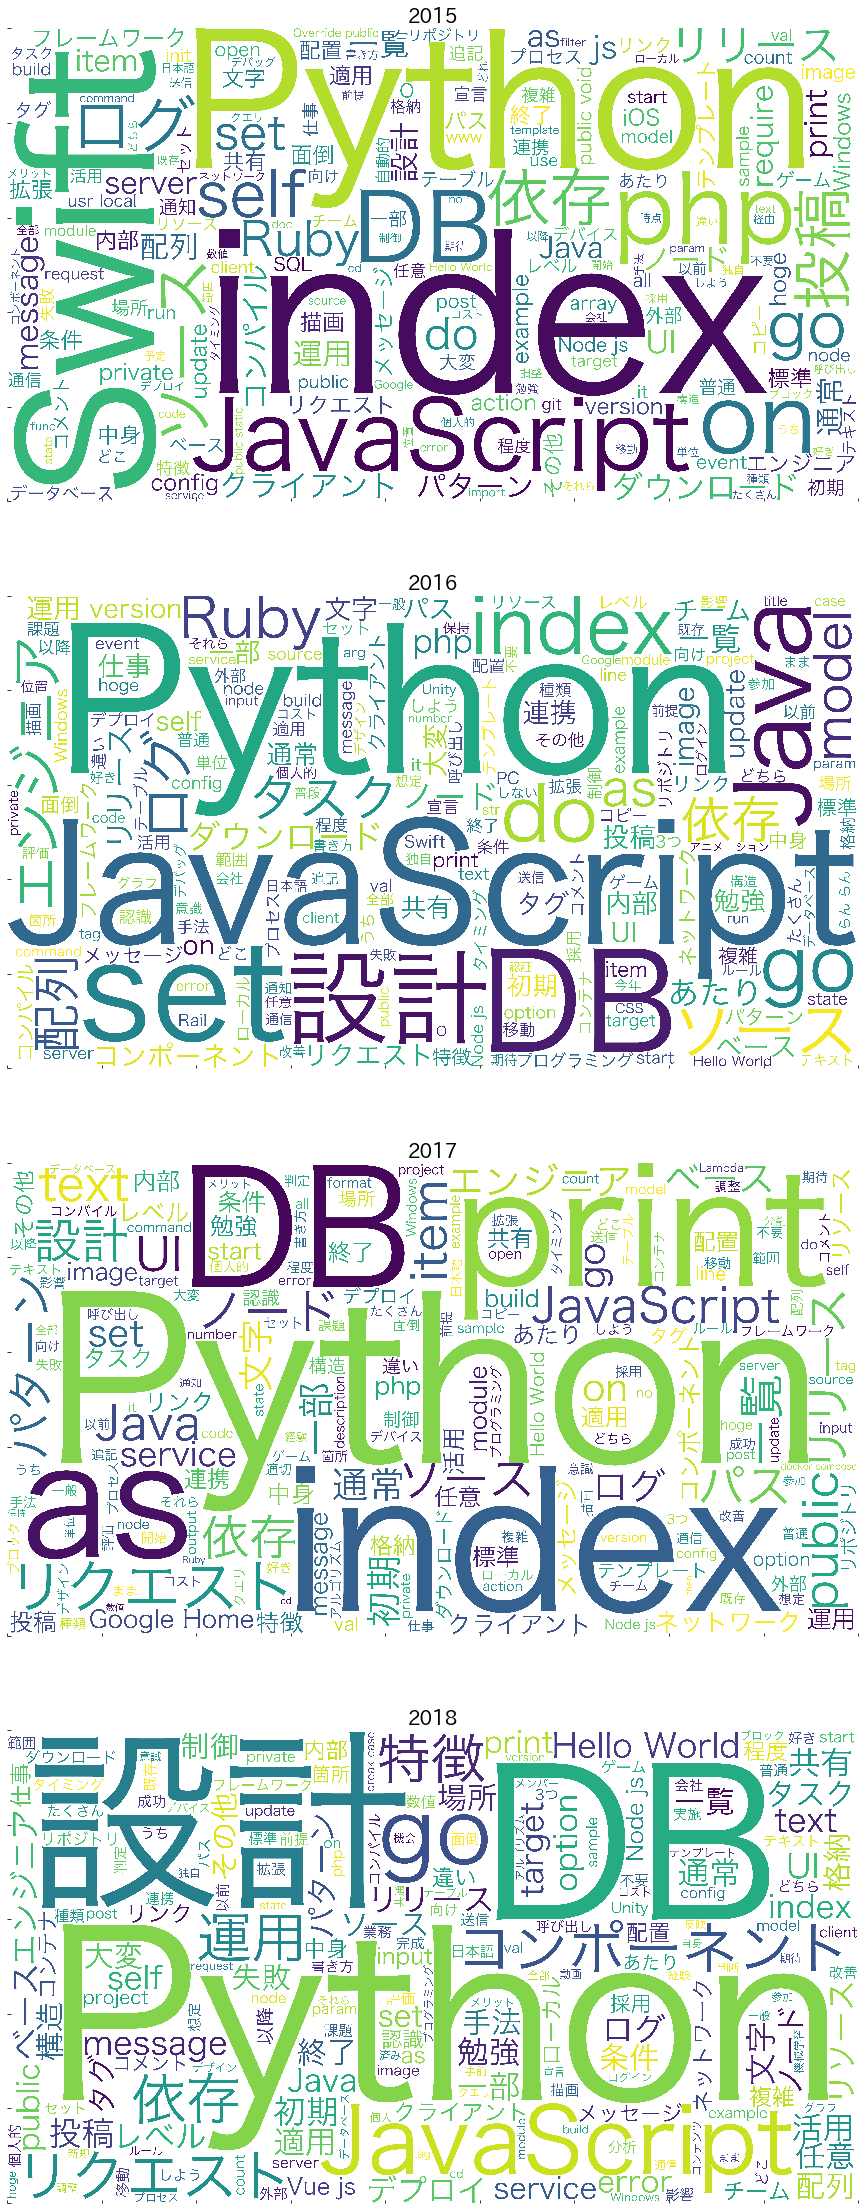

In [28]:
years = [2015, 2016, 2017, 2018]
n = len(years)
fig = plt.figure(figsize=(16, 10*n))
fpath = "/System/Library/Fonts/ヒラギノ角ゴシック W3.ttc"

for i, year in enumerate(years):
    wordcloud = WordCloud(
        background_color="white", width=900*10, height=500*10, font_path=fpath, stopwords=stop_words
    ).generate(" ".join(dic_words[year]))
    ax = fig.add_subplot(n, 1, i+1)
    ax.imshow(wordcloud)
    [spine.set_visible(False) for spine in ax.spines.values()]

    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.grid(False)
    ax.set_title(f'{year}', fontsize=20)